In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.optim import AdamW
import matplotlib.pyplot as plt

In [2]:
# Load dataset (adjust if CSV or XLS)
df = pd.read_csv("/content/drive/MyDrive/chatbot/ai_core.csv")

# Normalize columns
df.columns = df.columns.str.strip().str.lower()

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/chatbot/dialoGPT-small")
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/chatbot/dialoGPT-small")
model.train()


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
# Prepare prompts
texts = []
for _, row in df.iterrows():
    prompt = (
        f"Job Title: {row.get('job_title', '')}\n"
        f"Company: {row.get('company_name', '')}\n"
        f"Location: {row.get('company_location', '')}\n"
        f"Experience Level: {row.get('experience_level', '')}\n"
        f"Employment Type: {row.get('employment_type', '')}\n"
        f"Remote Ratio: {row.get('remote_ratio', '')}\n"
        f"Required Skills: {row.get('required_skills', '')}\n"
        f"Salary: {row.get('salary_usd', '')} {row.get('salary_currency', '')}\n"
        f"Education Required: {row.get('education_required', '')}\n"
        f"Years Experience: {row.get('years_experience', '')}\n"
        "Job Summary:"
    )
    full_text = prompt + tokenizer.eos_token
    texts.append(full_text)

# Tokenize with padding/truncation
encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Dataset and DataLoader
class JobDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return self.encodings.input_ids.size(0)
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1  loss: 13.1168
Epoch 1  loss: 11.8385
Epoch 1  loss: 10.1353
Epoch 1  loss: 8.8207
Epoch 1  loss: 7.7931
Epoch 1  loss: 6.8086
Epoch 1  loss: 6.0983
Epoch 1  loss: 5.3472
Epoch 1  loss: 4.9963
Epoch 1  loss: 4.5116
Epoch 1  loss: 4.0252
Epoch 1  loss: 3.6067
Epoch 1  loss: 3.3455
Epoch 1  loss: 3.1870
Epoch 1  loss: 2.8774
Epoch 1  loss: 2.6788
Epoch 1  loss: 2.5971
Epoch 1  loss: 2.4564
Epoch 1  loss: 2.3054
Epoch 1  loss: 2.1856
Epoch 1  loss: 2.1306
Epoch 1  loss: 2.1555
Epoch 1  loss: 2.0109
Epoch 1  loss: 1.9999
Epoch 1  loss: 1.8194
Epoch 1  loss: 1.7006
Epoch 1  loss: 1.6826
Epoch 1  loss: 1.7541
Epoch 1  loss: 1.6076
Epoch 1  loss: 1.6668
Epoch 1  loss: 1.5615
Epoch 1  loss: 1.4443
Epoch 1  loss: 1.4643
Epoch 1  loss: 1.3725
Epoch 1  loss: 1.3743
Epoch 1  loss: 1.3562
Epoch 1  loss: 1.3040
Epoch 1  loss: 1.2539
Epoch 1  loss: 1.2885
Epoch 1  loss: 1.2268
Epoch 1  loss: 1.2408
Epoch 1  loss: 1.1555
Epoch 1  loss: 1.1193
Epoch 1  loss: 1.1423
Epoch 1  loss: 1.1295
Epoch 1

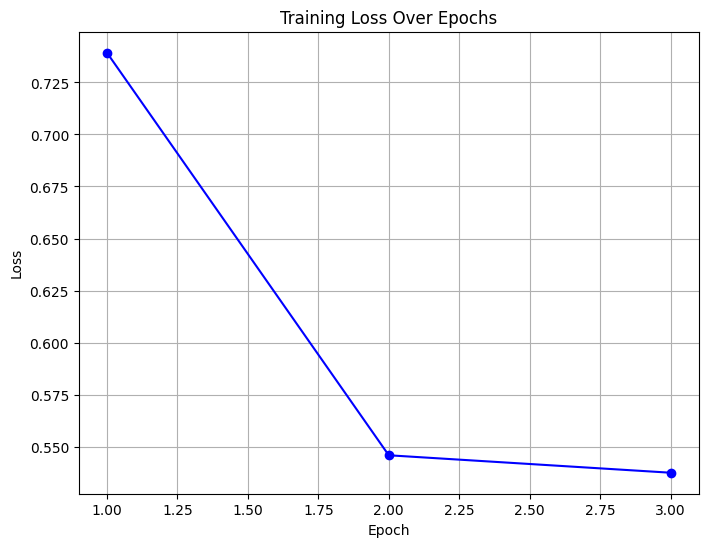

In [4]:
dataset = JobDataset(encodings)
batch_size = 16
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Optimizer and device
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 3
loss_values = []

for epoch in range(epochs):
    total_loss = 0
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch, labels=batch['input_ids'])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        print(f"Epoch {epoch + 1}  loss: {loss:.4f}")
    avg_loss = total_loss / len(loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")

# Save model/tokenizer
save_dir = "/content/drive/MyDrive/chatbot/model"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

# Plot losses
plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), loss_values, marker='o', color='blue')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/chatbot/training_loss_plot.png")
plt.show()


In [8]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_path = '/content/drive/MyDrive/chatbot/model'

tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)


def generate_answer(question, max_length=50):
    input_text = f"Question: {question}"
    inputs = tokenizer(input_text, return_tensors="pt")
    outputs = model.generate(**inputs, temperature=1.0, top_p=0.9, max_length=100,num_beams=4,do_sample=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

# Test questions
questions = [
    "What is the salary of Data Scientist?",
]

for q in questions:
    print(f"Q: {q}")
    print(f"A: {generate_answer(q)}")
    print("---")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Q: What is the salary of Data Scientist?
A: Question: What is the salary of Data Scientist? 0
Company: Algorithmic Solutions
Location: Singapore
Experience Level: EX
Employment Type: CT
Remote Ratio: 100
Required Skills: Python, TensorFlow, Kubernetes
Salary: 161830 USD
Education Required: Master
Years Experience: 19
Job Summary:
---


In [7]:
!ls /content/drive/MyDrive/chatbot/model


chat_template.jinja	merges.txt		 tokenizer_config.json
config.json		model.safetensors	 tokenizer.json
generation_config.json	special_tokens_map.json  vocab.json
